In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso, MultiTaskLasso
from sklearn.multioutput import MultiOutputRegressor

## Data

In [130]:
## Data

df = pd.read_csv('../../Datasets/AirQualityUCI_ready.csv', 
parse_dates=['Date_Time'], usecols=['Date_Time', 'CO_sensor' ,'RH'], index_col=['Date_Time'])

df.sort_index(inplace=True)

df = df.loc["2004-04-01":"2005-04-30"]

df = df.asfreq('1H')

df = df.fillna(method='ffill')

df.head()

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


## Feature Engineering Pipeline

In [131]:
date_feat = lambda : DatetimeFeatures(variables='index', 
            features_to_extract=['hour', 'month', 'week', 'weekend', 'day_of_month', 'day_of_week'])

cyclic_feat = lambda : CyclicalFeatures(variables=['hour', 'month'])

# Using only CO_sensor to create lags and window features
lag_feat = LagFeatures(variables=['CO_sensor'], freq=['1H','24H'], missing_values='ignore')
window_feat = WindowFeatures(variables=['CO_sensor'], freq='1H', window='3H', missing_values='ignore')



# Using  CO_sensor and RH to create lags and window features
lag_feat_RH = LagFeatures(variables=['CO_sensor','RH'], freq=['1H','24H'], missing_values='ignore')
window_feat_RH = WindowFeatures(variables=['CO_sensor','RH'], window='3H', freq='1H', missing_values='ignore')


drop_feat = lambda: DropFeatures(features_to_drop=['CO_sensor','RH'])
drop_missing = lambda : DropMissingData()


pipe_1 = Pipeline([ 
    ('date_feat', date_feat()),
    ('cyclic_feat', cyclic_feat()),
    ('lag', lag_feat),
    ('window', window_feat),
    ('drop_features', drop_feat()),
    ('drop_missing', drop_missing())
])


pipe_2 = Pipeline([ 
    ('date_feat', date_feat()),
    ('cyclic_feat', cyclic_feat()),
    ('lag', lag_feat_RH),
    ('window', window_feat_RH),
    ('drop_features', drop_feat()),
    ('drop_missing', drop_missing())
])

## Split Time Series

In [132]:
train = df.loc[df.index<"2005-03-04"]
test = df.loc[pd.to_datetime("2005-03-04")-pd.Timedelta(value='24H'):]


y_train = df.loc[train.index, ['CO_sensor', 'RH']]
y_test = df.loc[test.index, ['CO_sensor', 'RH']]


print(f'Train data start:{train.index.min()} \nTrain data end:{train.index.max()}')
print(f'Test data start:{test.index.min()} \nTest data end:{test.index.max()}')

Train data start:2004-04-04 00:00:00 
Train data end:2005-03-03 23:00:00
Test data start:2005-03-03 00:00:00 
Test data end:2005-04-04 14:00:00


## Train a model

In [133]:
X_train = pipe_1.fit_transform(train)
X_train_RH = pipe_2.fit_transform(train)

train_y = y_train.loc[X_train.index]
train_y_RH = y_train.loc[X_train_RH.index]

In [134]:
lasso = MultiOutputRegressor(Lasso()).fit(X_train, train_y)
lasso_RH = MultiOutputRegressor(Lasso()).fit(X_train_RH, train_y_RH)

## Recurisve forecasting

In [149]:
forecast_start = pd.Timestamp('2005-03-04')
forecast_end = forecast_start + pd.Timedelta(value='23H')

print(f'Forecasting air-pollution from {forecast_start} upto {forecast_end}')

index = pd.date_range(start=forecast_start, end=forecast_end, freq='H')

input_data = test.loc[forecast_start-pd.Timedelta('24H'):forecast_start].copy()
input_data.loc[forecast_start] = np.nan

input_data_RH = test.loc[forecast_start-pd.Timedelta('24H'):forecast_start].copy()
input_data_RH.loc[forecast_start] = np.nan

forecast_df = pd.DataFrame(index=index, columns=['CO_sensor_prediction', 'RH_prediction'])
forecast_df_RH = pd.DataFrame(index=index, columns=['CO_sensor_prediction', 'RH_prediction'])

for i in index:
    forecast_df.loc[i] = lasso.predict(pipe_1.transform(input_data))
    forecast_df_RH.loc[i] = lasso_RH.predict(pipe_2.transform(input_data_RH))

    input_data.loc[i] = forecast_df.loc[i].values
    input_data = input_data.shift(periods=-1).shift(freq='1H')

    input_data_RH.loc[i] = forecast_df_RH.loc[i].values
    input_data_RH = input_data_RH.shift(periods=-1).shift(freq='1H')



Forecasting air-pollution from 2005-03-04 00:00:00 upto 2005-03-04 23:00:00


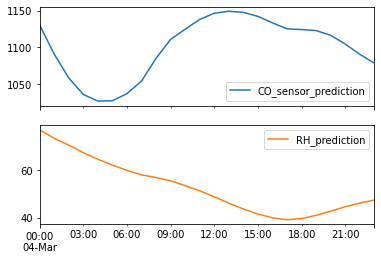

In [167]:
forecast_df.plot(subplots=True);


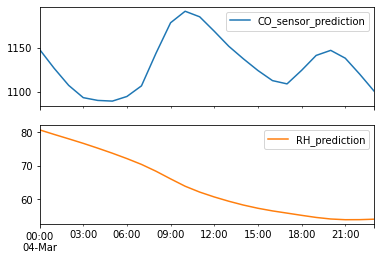

In [166]:
forecast_df_RH.plot(subplots=True);

## Visualization

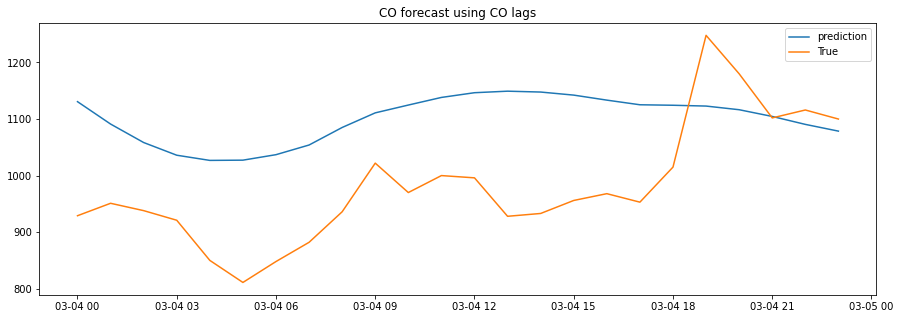

In [176]:
plt.figure(figsize=(15,5))
plt.plot(forecast_df['CO_sensor_prediction'], label='prediction')
plt.plot(y_test.loc[forecast_df.index, ['CO_sensor']], label='True')
plt.title('CO forecast using CO lags')
plt.legend();

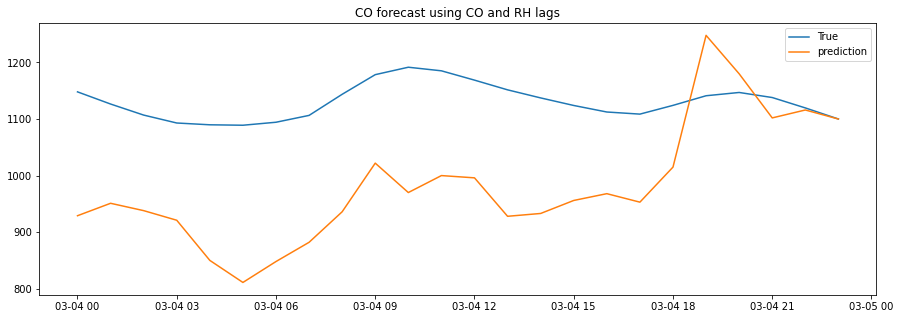

In [177]:
plt.figure(figsize=(15,5))
plt.plot(forecast_df_RH['CO_sensor_prediction'], label='True')
plt.plot(y_test.loc[forecast_df.index, ['CO_sensor']], label='prediction')
plt.title('CO forecast using CO and RH lags')
plt.legend();

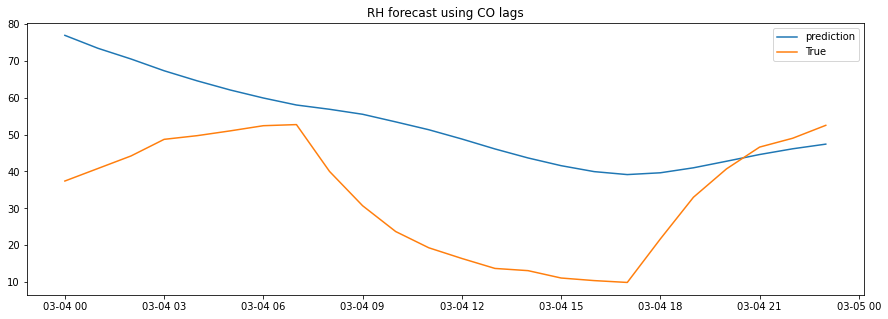

In [179]:
plt.figure(figsize=(15,5))
plt.plot(forecast_df['RH_prediction'], label='prediction')
plt.plot(y_test.loc[forecast_df.index, ['RH']], label='True')
plt.title('RH forecast using CO lags')
plt.legend();

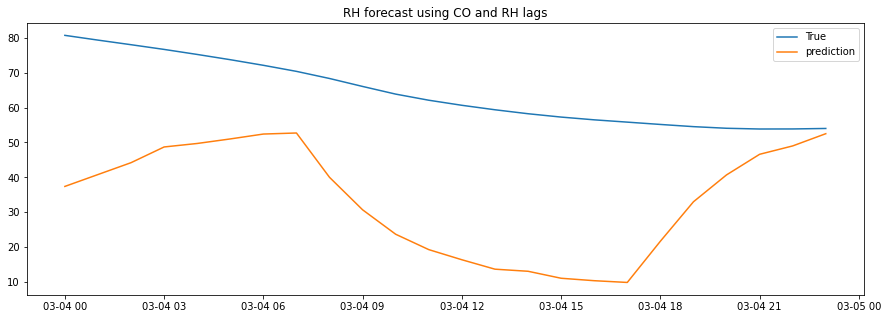

In [180]:
plt.figure(figsize=(15,5))
plt.plot(forecast_df_RH['RH_prediction'], label='True')
plt.plot(y_test.loc[forecast_df.index, ['RH']], label='prediction')
plt.title('RH forecast using CO and RH lags')
plt.legend();

In [187]:
y_preds =  forecast_df.merge(forecast_df_RH, left_index=True, right_index=True, suffixes=['','_with_RH'])
y_preds.merge(y_test, left_index=True, right_index=True, suffixes=['', '_TRUE'])

,CO_sensor_prediction,RH_prediction,CO_sensor_prediction_with_RH,RH_prediction_with_RH,CO_sensor,RH
2005-03-04 00:00:00,1130.736821,76.896663,1148.06485,80.663507,929.0,37.4
2005-03-04 01:00:00,1091.139054,73.389825,1126.53853,79.303155,951.0,40.8
2005-03-04 02:00:00,1058.449603,70.483294,1106.994187,77.985216,938.0,44.2
2005-03-04 03:00:00,1036.005757,67.298271,1092.98977,76.637419,921.0,48.7
2005-03-04 04:00:00,1026.84894,64.561404,1089.819689,75.195377,850.0,49.7
2005-03-04 05:00:00,1027.272985,62.078147,1089.042858,73.691282,811.0,51.0
2005-03-04 06:00:00,1036.972306,59.908026,1094.327618,72.08557,848.0,52.4
2005-03-04 07:00:00,1054.079015,58.008902,1106.440995,70.350084,882.0,52.7
2005-03-04 08:00:00,1085.076438,56.85403,1143.762757,68.309278,936.0,40.0
2005-03-04 09:00:00,1110.9249,55.498815,1178.497206,66.030904,1022.0,30.7
